# ANAND PATEL

# Wikipedia Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2022`__

Implement distributed PageRank using some data from Wikipedia.
By the end of this notebook we:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

---
Completed in Databricks

# Notebook Set-Up
Before starting run the following cells to confirm your setup.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import pickle

In [0]:
# RUN THIS CELL AS IS. 
tot = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
for item in dbutils.fs.ls(DATA_PATH):
  tot = tot+item.size
tot
# ~4.7GB

Out[2]: 4751198766

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
sc = spark.sparkContext
spark

Out[4]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.28:7077 
 AppName 
 Databricks Shell

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ A social network dataset, like from Facebook or Instagram, would be appropriate to represent as a graph. Let's take Instagram as our example. The nodes would be individual accounts/user profiles and the edges between a starting and ending node would represent if the starting user follows the ending user. The graph is directed because each edge indicates the first account following the second account, and this interaction is one-way. A seperate edge going from account 2 to account 1 is needed to show a "follow back". The average in-degree of a node means the number of accounts following the particular account associated with this node.

> __b)__ Graphs are hard to work with in map-reduce paradigm because each edge references information about other nodes. Since nodes have information about other nodes, it can be hard to process each node as an individual record.

> __c)__ Dijskra's algorithm finds the single source shortest path on a weighted graph. While exploring the graph from the starting node, it uses a priority queue to keep track of a frontier of nodes to expand next. The priority is deceided by the order of their total distance from the starting node. If a shorter distance to a node from the starting node is found, that distance replaces the longer path. The priority queue is used to choose the next node to expand, and the one with the shortest distance to start is popped from the queue. Once the queue is empty, all the shortest paths from our starting node have been discovered.
>
> This algorithm is hard to parallelize because we would need to keep a priority queue in memory for all workers, and this does not scale well with a large graph where we might have many nodes in the queue at a time. 
>
> Insertion into priority queue is a sequential operation. 

> __d)__ Parallel BFS solves this problem by adding a field to keep track of the node's status (`unvisited`, `queue`, `visited`) to tell the algorithm if each node/record should be expanded. This gets rid of a priority queue that would have tracked the nodes to be visited next.
> 
> The expense of this design is that we need to do multiple iterations over the entire dataset to change and process these node statuses as we explore all the nodes in the graph.

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ This graph from figure 5.1 in Lin & Dyer is sparse. There are mostly 0 entries in the adjacency matrix (16/25 possible edges are 0), making the graph sparse. A sparse graph will include fewer potential edges between all nodes, and the adjacency matrix will have more 0 entries there as a result. This representation is not memory efficient because we are storing data on all these 0 entries. On the other hand, the adjacency lists for a sparse matrix are short for each node and much more efficient for memory storage because we do not need to store 0's. We just store 1's.

> __b)__ This is a directed graph because we see edges as 1-way, arrow connections between nodes. There is an edge from A to B, and this is only one way. We would need an edge from B to A as a seperate relationship in this graph. Adjacency matricies for directed graphs require the order to matter, and are not symmetrical like they are for undirected graphs. This means that an entry for (A,B) can have a different value than (B,A) as we do here (`1`, and `0` respectively).

In [0]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

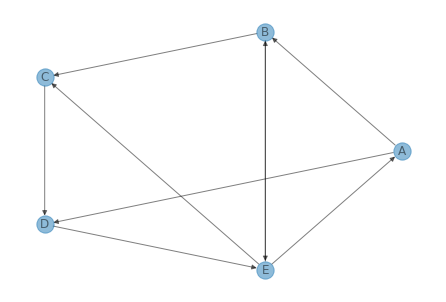

In [0]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
print(TOY_GRAPH["edges"])

[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), ('D', 'E'), ('E', 'A'), ('E', 'B'), ('E', 'C')]

In [0]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for edge in graph["edges"]:
      start_n, end_n = edge
      adj_matr[end_n][start_n] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

A B C D E
A 0 1 0 1 0
B 0 0 1 0 1
C 0 0 0 1 0
D 0 0 0 0 1
E 1 1 1 0 0

In [0]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for edge in graph["edges"]:
      start_n, end_n = edge
      adj_list[start_n].append(end_n)
    
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}

# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ PageRank measures how important a webpage is based on how many times this page is linked to other webpages. In the the context of the infinite random walk, PageRank metric for a node/webpage represents how much time the random walker spends on that given node/webpage. Each node will have a PageRank metric assigned to it, and they represent the probability distribution over all the nodes/webpages for how likely the surfer is to be at that particular node at a given time during the random walk. Higher scores mean more people are likely to frequent this webpage, so it must be an important page relative to others in the graph.

> __b)__ A Markov chain is a mathematical system that undergoes transitions from one state to another, between a finite or countable number of possible states.
	The "Markov Property" is characterized by memoryless: The next state depends only on the current state and not on the sequence of events that preceded it. In the context of PageRank, it means that the probability of going to the next page is only dependent on the current page (which pages are linked from here) and not the entire path or web browsing history before it. 

> __c)__ The `n` states are the webpages in our web graph. This implies that the transition matrix, of size $n^2$, will be very large since `n` is the number of webpages out on the web. The number of pages on the web is estimated to be in the trillions. 

> __d)__ A right stochastic matrix is a square matrix of nonnegative real numbers, with each row summing to 1 (async). A right stochastic matrix represents a graph where the weight of out-edges from a node all sum to 1. Therefore, each row in this matrix should sum to 1.

> __e)__ The stable state distribution (PageRank) of the graph converges by iteration 7. Node E is the most central node because it has the highest steady state probability, and we expect this from visual inspection.

In [0]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

Out[12]:

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [0]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = TOY_ADJ_MATR/np.array(TOY_ADJ_MATR).sum(axis=1, keepdims=True) # replace with your code

################ (END) YOUR CODE #################
print(transition_matrix)

A B C D E
A 0.000000 0.500000 0.000000 0.5 0.0
B 0.000000 0.000000 0.500000 0.0 0.5
C 0.000000 0.000000 0.000000 1.0 0.0
D 0.000000 0.000000 0.000000 0.0 1.0
E 0.333333 0.333333 0.333333 0.0 0.0

In [0]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing initial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    # calculate state vector
    # print(xInit.shape)
    state_vector = xInit.dot(tMatrix) # step 1: x_1^T = x_0^T * P
    # print(state_vector.shape)
    for i in range(nIter):
      if verbose:
        print(f"Step {i}\tstate vector: {state_vector}")
      tMatrix = tMatrix.dot(tMatrix) # multiply matrix with itself to make new one: P*P
      state_vector = xInit.dot(tMatrix) # get the state vector at this iteration: x_1^T = x_0^T * P*P
    
    
    
    ################ (END) YOUR CODE #################
    return state_vector

In [0]:
a = np.array([[ 5, 1 ,3], 
                  [ 1, 1 ,1], 
                  [ 1, 2 ,1]])
b = np.array([1, 2, 3])
print(a.shape)
print(a)
print(b.shape)
print(b)
# print(a.dot(b))
print(b.dot(a))

(3, 3)
[[5 1 3]
 [1 1 1]
 [1 2 1]]
(3,)
[1 2 3]
[10 9 8]

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Step 0	state vector: [0. 0.5 0. 0.5 0. ]
Step 1	state vector: [0. 0. 0.25 0. 0.75]
Step 2	state vector: [0. 0.125 0.125 0.375 0.375]
Step 3	state vector: [0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
Step 4	state vector: [0.10386392 0.15674096 0.18360648 0.23753577 0.31825288]
Step 5	state vector: [0.10526656 0.15789725 0.18421194 0.23683994 0.3157843 ]
Step 6	state vector: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 7	state vector: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 8	state vector: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 9	state vector: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:
> __a)__ The probabilities are not converging, and with each iteration they become smaller and smaller. The row of probabilities should sum to 1 but these do not. 

> __b)__ The dangling node is E because it is a sink for edges but has no outgoing edges. For a Markov Chain and PageRank to work, we need stochasticity and this fails because the dangling node does not redistribute the incoming mass.

> __c)__ A graph is irreducible if there is a path from every node to every other node. The webgraph is not naturally irreducible because some webpages cannot reach other webpages without typing into the URL since a hyperlink chain might not exist. 
 

> __d)__ A graph is aperiodic if the period, or greatest common divisor (GCD), of all cycle lengths is 1. Aperiodicity: When starting from some state i, we don't know when we will return to the same state i after some transition. We may see the state i after 1,2,3,4,5.. etc number of transition ([source](https://stats.stackexchange.com/a/385070)). A webgraph is naturally aperiodic because we just need 1 page to have a hyperlink back to itself for the minimum period to be 1. This is commonly found on the huge internet. 

> __e)__ PageRank modifies the webgraph to include a teleportation chance so that each node, and particularly dangling nodes, are escapable by the random surfer who ends up on that page. This connects all nodes in the graph and provides irreducibility. Having a webpage link to itself in the webgraph can guarantee aperiodicity. Lastly, redistributing the probability mass of dangling node webpages to the rest of the nodes/webpages in the graph allow us to handle dangling nodes. These changes amount to the Stochasticity adjustment and Primitivity adjustment, which allow us to guarantee aperiodicity and irreducibility.

In [0]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

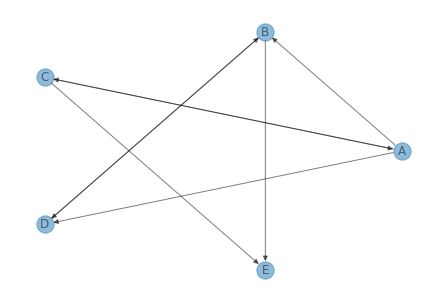

In [0]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################

# get the adjacency matrix
print("Adjacency Matrix:")
TOY_ADJ_MATR2 = np.array(get_adj_matr(TOY2_GRAPH))
print(TOY_ADJ_MATR2)
print("\n")


# calculate transition matrix, 0's if whole row sums to 0.
print("Transition Matrix:")
transition_matrix2 = np.zeros(TOY_ADJ_MATR2.shape) # initialize 0's for transition matrix
for i, row in enumerate(TOY_ADJ_MATR2):
  # update row if the sum of entries in row is greater than 0. Avoid division by 0
  if np.sum(row) > 0:
    transition_matrix2[i] = np.array(row) / np.sum(row)
print(transition_matrix2)
print("\n")

print("Power Iterations")
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix2, 10, verbose = True)
################ (END) YOUR CODE #################

Adjacency Matrix:
[[0 1 1 1 0]
 [0 0 0 1 1]
 [1 0 0 0 1]
 [0 1 0 0 0]
 [0 0 0 0 0]]


Transition Matrix:
[[0. 0.33333333 0.33333333 0.33333333 0. ]
 [0. 0. 0. 0.5 0.5 ]
 [0.5 0. 0. 0. 0.5 ]
 [0. 1. 0. 0. 0. ]
 [0. 0. 0. 0. 0. ]]


Power Iterations
Step 0	state vector: [0. 0.33333333 0.33333333 0.33333333 0. ]
Step 1	state vector: [0.16666667 0.33333333 0. 0.16666667 0.33333333]
Step 2	state vector: [0.02777778 0.22222222 0. 0.11111111 0.13888889]
Step 3	state vector: [0.0007716 0.0617284 0. 0.0308642 0.0316358]
Step 4	state vector: [5.95374181e-07 3.90565463e-03 0.00000000e+00 1.95282731e-03
 1.95342269e-03]
Step 5	state vector: [3.54470415e-13 1.52587887e-05 0.00000000e+00 7.62939435e-06
 7.62939471e-06]
Step 6	state vector: [1.25649275e-25 2.32830644e-10 0.00000000e+00 1.16415322e-10
 1.16415322e-10]
Step 7	state vector: [1.57877404e-50 5.42101086e-20 0.00000000e+00 2.71050543e-20
 2.71050543e-20]
Step 8	state vector: [2.49252746e-100 2.93873588e-039 0.00000000e+000 1.46936794e-039
 1.46936794e-039]
Step 9	state vector: [6.21269312e-200 8.63616856e-078 0.00000000e+000 4.31808428e-078
 4.31808428e-078]

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [0]:
dbutils.fs.ls(DATA_PATH)

Out[20]: [FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt', name='all-pages-indexed-in.txt', size=2143300687),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt', name='all-pages-indexed-out.txt', size=2090459616),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/indices.txt', name='indices.txt', size=517438296),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/test_graph.txt', name='test_graph.txt', size=167)]

In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

Out[23]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
testRDD.collect()

Out[24]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

Out[25]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

Out[26]: ["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The data in `testRDD` appears to be an adjacency list. The first value represents a node id for a given webpage. The second part of each line is a dictionary with keys of linked webpages, or node ids, that the main webpage links to and values for the number of times that webpage is linked in the main webpage. 

> __b)__ Records in the raw dataset are just pages that include hyperlinks to various other pages. That's what this count of records returns. Pages can exist on wikipedia without containing any hyperlinks to other pages. These pages can still be linked to, particularly by the records we are counting, but do not contain links to other pages themselves. These nodes will not have any out-edges so they will not have a record in the raw dataset, but they will still have in-edges and be referenced in the adjacency lists so they are still part of the graph. These would still be nodes in our graph and contribute to the total number of nodes, but won't be included in the total number of records.

> __d)__ The dangling nodes are defined as nodes that do not link to any other nodes, and serve as a sink for edges. Dangling nodes are nodes in the graph that have no outgoing edges (dead-end nodes), i.e., their adjacency lists are empty. We calculate the number of them by subtracting the total number of nodes in the graph by the total number of records in the raw dataset (starting nodes): `15,192,277 - 5,781,290 = 9,410,987`

In [0]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290

In [0]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def emitNodes(line: str):
      """
      emmit all nodes from the record
      input: rawstr example: "4\t{'1': 1, '2': 1}"
      output: ['4', '1', '2']
      """
      node, edges_dict_str = line.split('\t')
      edges_dict = ast.literal_eval(edges_dict_str)
      return [str(node)] + list(edges_dict.keys())
    
    totalCount = dataRDD.flatMap(emitNodes) \
                        .distinct() \
                        .count()
    
    
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.9062819480895996 seconds.
Total Nodes: 11

In [0]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 305.6630401611328 seconds.
Total Nodes: 15192277

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ A node's out-degree is used to divide the node's current PageRank value and redistribute that value (referred to sometimes as 'mass') to each neighbor during a single iteration. 

> __c)__ A node's out-degree being 0 means this is a dangling node and it serves as a sink for mass being distributed to them because they have no out going edges to redistribute that mass. PageRank must handle these nodes differently to meet the stochasticity requirement for steady state convergence, so it will accumulate the incoming mass to all these nodes in a global total and redistribute it equally to all nodes in the graph each iteration.

In [0]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    # calculate RDD for getting out-degree of node
    # node's out-degree is the sum of all its links
    out_deg_RDD = dataRDD.map(parse) \
                          .mapValues(lambda edges_dict: np.sum(list(edges_dict.values()))) \
                          .cache()
    
    # get the top 10 pages by the out-degree
    top = out_deg_RDD.takeOrdered(10, key=lambda x: -x[1])
    avgDegree = out_deg_RDD.map(lambda x: x[1]).mean()
    sampledCounts = out_deg_RDD.map(lambda x: x[1]).takeSample(False, n, 2018)
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [0]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 0.5714907646179199 seconds
Average out-degree: 2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('3', 2), ('4', 2), ('7', 2), ('8', 2), ('9', 2), ('11', 2), ('2', 1), ('10', 1)]

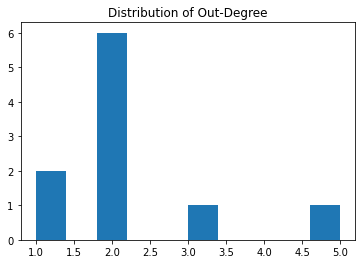

In [0]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 197.37449645996094 seconds
Average out-degree: 32.04181575392317
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904)]

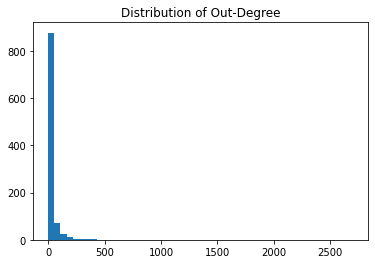

In [0]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q7 Tasks:
* __a) short response:__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

In [0]:
temp_dict = {'1':2, '2':3}
temp_dict2 = {'3':2, '2':3}
print(temp_dict.keys())

print({str(k): float(v) for k,v in temp_dict.items()})
print({**temp_dict, **temp_dict2})

dict_keys(['1', '2'])
{'1': 2.0, '2': 3.0}
{'1': 2, '2': 3, '3': 2}

### Q7 Student Answers:

> __a)__ N is the number of webpages/nodes in the web graph, and we initialize each node's rank to \\(\frac{1}{N}\\) because it gives an equal probability initially of the random web-surfer of being on any of these pages at a time *t*. As we do iterations, these PageRank values will move from equal probability to the steady state probability.

> __b)__ It would be more efficient to compute N after initializing records because it can be done without a second MR job or shuffle. **NEED TO VERIFY**.

In [0]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    def parse(line: str):
      """
      flatMap: emmit all nodes from the record
      input: rawstr example: "4\t{'1': 2, '2': 1}"
      output: ('1', {}), ('2', {}), ('4', {'1': 2, '2': 1})
      """
      node, edges_dict_str = line.split('\t')
      edges_dict = ast.literal_eval(edges_dict_str)
      # emit neighbors with empty neighbor dict
      for edge in edges_dict.keys():
        yield (str(edge), dict())
      # yield this node and its neighbor list preserved
      # new_nbr_dict = {str(k): float(v) for k,v in edges_dict.items()}
      yield (str(node), edges_dict)
      
    def combineNbrDict(a: dict, b:dict):
      """
      reduceByKey: combine the nbr dictionaries for the common key
      """
      return {**a, **b}
    

    
    # write your main Spark code here
    
    # initialize RDD with the adjacency list for every single node in graph
    initialRDD = dataRDD.flatMap(parse) \
                        .reduceByKey(combineNbrDict)
    
    # broadcast the node count
    N = sc.broadcast(initialRDD.count())
    
    # create the graphRDD formated above
    graphRDD = initialRDD.mapValues(lambda x: (1/float(N.value), x)).cache()
    
    
    
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.43741607666015625 seconds.
Out[38]: [('1', (0.09090909090909091, {})),
 ('4', (0.09090909090909091, {'1': 1, '2': 1})),
 ('8', (0.09090909090909091, {'2': 1, '5': 1})),
 ('9', (0.09090909090909091, {'2': 1, '5': 1})),
 ('10', (0.09090909090909091, {'5': 1})),
 ('3', (0.09090909090909091, {'2': 2})),
 ('2', (0.09090909090909091, {'3': 1})),
 ('6', (0.09090909090909091, {'2': 1, '5': 2})),
 ('5', (0.09090909090909091, {'4': 3, '2': 1, '6': 1})),
 ('7', (0.09090909090909091, {'2': 1, '5': 1})),
 ('11', (0.09090909090909091, {'5': 2}))]

In [0]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 492.0029571056366 seconds

In [0]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('15064512', (6.582291778908455e-08, {}))]
... initialization continued: 119.18934941291809 seconds

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ This term: $$\alpha * \frac{1}{|G|}$$ means that we are adding a probability to this node scaled by a teleportation factor $\alpha$ to capture the scenario where a random walker is teleporting to this node. A random surfer is equally likely to teleport to any of the nodes in the graph, so the probability is divided by the total number of nodes |G| to make this term equal for all nodes.

> __b)__ In the calculation, $m$ represents the Dangling Mass that is accumulated from all the dangling nodes in the graph. We must equally distribute this mass to all nodes in the graph, so that is why we divide it by $|G|$ in the calculation.

> __c)__ After each iteration, the total mass should be 1. This is because it is the sum of the probabilities for all nodes in the graph.

In [0]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
temp = {'2': 1, '5': 2}
np.sum([weight for weight in temp.values()])

Out[42]: 3

In [0]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
    def getEdgeWeight(payload: tuple):
      """
      Used in MapValues: add the total edge weight to each record. Equivalent to edge count for unweighted graphs.
      total_weight = 0 for dangling node
      Input: (0.09090909090909091, {'2': 1, '5': 2})
      Output: (0.09090909090909091, 3, {'2': 1, '5': 2})
      """
      score, edge_dict = payload
      if len(edge_dict) == 0:
        tot_weight = 0
      else:
        tot_weight = np.sum([weight for weight in edge_dict.values()]) # get the total weight: sum of edge_weights
      return (score, tot_weight, edge_dict)

    def accumulateMass(record: tuple, mmAccum, totAccum):
      """
      Used in foreach: takes a record and sends its mass to dangling mass accumulator and/or total mass accumulator
      Input: ('4', (0.09090909090909091, 3, {'2': 1, '5': 2}))
      """
      node, (score, tot_weight, edges) = record
      # send to dangling mass accumulator if this record is a dangling node
      if tot_weight == 0:
        mmAccum.add(score)
      totAccum.add(score)
    
    def redistributeMass(record: tuple):
      """
      Used in flatmap: takes in a record and redistributes the node's current score to each of its neighbors
      Input: ('4', (0.09090909090909091, 3, {'2': 1, '5': 2}))
      Output: ('2', (09090909090909091 * (1/3), 0, {}), ('5', (09090909090909091 * (2/3), 0, {}), ('4', (0, 3, {'2': 1, '5': 2}))
      """
      node, (score, tot_weight, edges) = record
      # emit partials for neighbors
      if len(edges) != 0:
        for k,weight in edges.items():
          yield (k, (score * (weight/tot_weight), 0, {}))
      # emit graph structure
      yield (node, (0, tot_weight, edges))
    
    def combinePageRank(a, b):
      """
      reduceByKey: combine records
      input: (0, 3, {'2': 1, '5': 2}), (.25, 0, {})
      output: (0.25, 3, {'2': 1, '5': 2})
      """
      score_a, tot_weight_a, edges_a = a
      score_b, tot_weight_b, edges_b = b
      
      # add up the scores together
      score = score_a + score_b
      
      # pick the larger of the 2 tot_weight's
      tot_weight = max(tot_weight_a, tot_weight_b)
      
      # pick larger of 2 neighbor edges 
      if len(edges_a) > len(edges_b):
        edges = edges_a
      else:
        edges = edges_b
        
      return (score, tot_weight, edges)
    
    def calculatePageRankScore(record, a, d, N, mm):
      """
      Use in map: recalculates PageRank Score with the values for teleportation and dangling mass.
      Input: ('4', (0.2, 3, {'2': 1, '5': 2}))
      a: teleportation factor
      d: damping factor
      N: total number of nodes
      mm: dangling mass
      Output: ('4', (0.13, 3, {'2': 1, '5': 2}))
      
      """
      node, (score, tot_weight, edges) = record
      score = a*(1/N) + d*( (mm/N) + score )
      return (node, (score, tot_weight, edges))
    
        
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    
    # add total weight to records
    graphRDD = graphInitRDD.mapValues(getEdgeWeight)
    N = sc.broadcast(graphRDD.count()) # get total number of records
    
    # do the iterations
    for i in range(maxIter):
      # get the total mass, dangling mass accumulated values
      graphRDD.foreach(lambda x: accumulateMass(x, mmAccum, totAccum))

      
      #broadcast the dangling mass value for use in PageRank calculation later
      mm = sc.broadcast(mmAccum.value)
    
      # run PageRank iteration
      graphRDD = graphRDD.flatMap(redistributeMass) \
                          .reduceByKey(combinePageRank) \
                          .map(lambda x: calculatePageRankScore(x, a.value, d.value, N.value, mm.value)) \
                          .cache()
    
      # print verbose results
      if verbose:
        print(f'STEP {i}: missing mass = {mm.value}, total = {totAccum.value}')
      
      # reset accumulators
      mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
      totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
      
      
    steadyStateRDD = graphRDD.mapValues(lambda x: x[0]) # get the final scores for each node
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 3.9971609115600586 seconds.
Top 20 ranked nodes:
Out[88]: [('2', 0.3620640495978871),
 ('3', 0.333992700474142),
 ('5', 0.08506399429624555),
 ('4', 0.060309635084734546),
 ('1', 0.04255740809817991),
 ('6', 0.03138662354831139),
 ('8', 0.01692511778009981),
 ('9', 0.01692511778009981),
 ('10', 0.01692511778009981),
 ('7', 0.01692511778009981),
 ('11', 0.01692511778009981)]

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [0]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

STEP 0: missing mass = 0.6194586235839131, total = 0.9999999999336477
STEP 1: missing mass = 0.4962366552052515, total = 0.9999999999744071
STEP 2: missing mass = 0.45845896638838757, total = 0.999999999979573
STEP 3: missing mass = 0.44518624578839316, total = 0.9999999999747424
STEP 4: missing mass = 0.44020147817974753, total = 0.9999999999792599
STEP 5: missing mass = 0.43818412109073224, total = 0.9999999999821725
STEP 6: missing mass = 0.43732676185870634, total = 0.9999999999853733
STEP 7: missing mass = 0.4369451581408971, total = 0.9999999999927052
STEP 8: missing mass = 0.4367684897169974, total = 0.9999999999925002
STEP 9: missing mass = 0.4366834304247518, total = 0.9999999999904636
...trained 10 iterations in 8701.27070403099 seconds.
Top 20 ranked nodes:
Out[89]: [('13455888', 0.0015447247129693911),
 ('4695850', 0.0006710240718848092),
 ('5051368', 0.0005983856809695475),
 ('1184351', 0.0005982073536424897),
 ('2437837', 0.0004624928928899071),
 ('6076759', 0.0004550940064106147),
 ('4196067', 0.0004423778888333771),
 ('13425865', 0.0004415535171391712),
 ('6172466', 0.0004224002001809195),
 ('1384888', 0.0004012895604045914),
 ('6113490', 0.0003957892477153099),
 ('14112583', 0.0003943847283716383),
 ('7902219', 0.00037009878473248447),
 ('10390714', 0.00036502649642948683),
 ('12836211', 0.0003619948863075223),
 ('6237129', 0.00035195558475935963),
 ('6416278', 0.00034866235644963236),
 ('13432150', 0.00033936510637098646),
 ('1516699', 0.00033297500285947053),
 ('7990491', 0.00030760906265574314)]

In [0]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
top_20

Out[99]: [('13455888', 0.0015447247129693911),
 ('4695850', 0.0006710240718848092),
 ('5051368', 0.0005983856809695475),
 ('1184351', 0.0005982073536424897),
 ('2437837', 0.0004624928928899071),
 ('6076759', 0.0004550940064106147),
 ('4196067', 0.0004423778888333771),
 ('13425865', 0.0004415535171391712),
 ('6172466', 0.0004224002001809195),
 ('1384888', 0.0004012895604045914),
 ('6113490', 0.0003957892477153099),
 ('14112583', 0.0003943847283716383),
 ('7902219', 0.00037009878473248447),
 ('10390714', 0.00036502649642948683),
 ('12836211', 0.0003619948863075223),
 ('6237129', 0.00035195558475935963),
 ('6416278', 0.00034866235644963236),
 ('13432150', 0.00033936510637098646),
 ('1516699', 0.00033297500285947053),
 ('7990491', 0.00030760906265574314)]

In [0]:
# Put at the top of any notebooks for storing in blob

from pyspark.sql.functions import col, max

# Save the top_20 results to disc for use later. So you don't have to rerun everything if you restart the cluster.
blob_container = "team06" # The name of your container created in https://portal.azure.com
storage_account = "apatel" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team06" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team06" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

with open(f"HW5_top20_RDD.data", "wb") as fp:   #Pickling
  pickle.dump(top_20, fp)

# top_20.saveAsTextFile(f"{blob_url}/HW5_top20_RDD") # Couldn't figure out how to save list to blob storage

In [0]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

Out[107]: ['! $var = &quot;&quot;\t1\t1\t0']

In [0]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

Out[109]: [(1, '! $var = &quot;&quot;'), (2, '! (CONFIG.SYS directive)')]

In [0]:
# read back top 20 from blob
# top_20_RDD_readback = sc.textFile(f"{blob_url}/HW5_top20_RDD")

In [0]:
with open('HW5_top20_RDD.data', 'rb') as filehandle:
    # read the data as binary data stream
    top_20_readback = pickle.load(filehandle)

top_20_RDD_readback = sc.parallelize(top_20_readback)

In [0]:
top_20_RDD_readback.take(1)

Out[111]: [('13455888', 0.0015447247129693911)]

# OPTIONAL
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

In [ ]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############
joinedWithNames = namesKV_RDD.join(top_20_RDD) \
                             .sortBy(ascending=False, keyfunc=lambda k: k[1][1]) \
                             .collect()
############## END YOUR CODE ###############

In [ ]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

```
PageRank  	| Page id   	| Title
====================================================================================================
0.001545	|   13455888	| United States
0.000671	|    4695850	| France
0.000598	|    5051368	| Germany
0.000598	|    1184351	| Animal
0.000462	|    2437837	| Canada
0.000455	|    6076759	| India
0.000442	|    4196067	| England
0.000442	|   13425865	| United Kingdom
0.000422	|    6172466	| Iran
0.000401	|    1384888	| Arthropod
0.000396	|    6113490	| Insect
0.000394	|   14112583	| World War II
0.000370	|    7902219	| List of sovereign states
0.000365	|   10390714	| Poland
0.000362	|   12836211	| The New York Times
0.000352	|    6237129	| Italy
0.000349	|    6416278	| Japan
0.000339	|   13432150	| United States Census Bureau
0.000333	|    1516699	| Australia
0.000308	|    7990491	| London
```